Happy holidays! 

My name is The Minh Nguyen (20256400). This notebook is my project for reimplementing and visualizing the results from the paper "On a stochastic programming model for inventory planning" https://www.researchgate.net/publication/228742876_On_a_stochastic_programming_model_for_inventory_planning


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import rankdata
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import pandas as pd
from pulp import *
import time

# Toy example for primal and dual algorithm

We will start with a toy example to make sure the implemented algorithms work correctly.

Set parameters d and c like in paper

In [2]:
# cumulative demand
d = [2, 4, 7, 7, 9, 6, 8]
# production cost
c = [5, 3, 4, 4, 1, 2, 6]

Build the scenario tree with Index System 1 for Primal Algorithm

Note that the root node is 0 instead of 1 to avoid the confusion between index and node in the code. This change will not affect the algorithms and results.

In [3]:
def add_children(graph, parent, num_levels, branching_factor):
    if num_levels == 0:
        return

    for i in range(branching_factor):
        child = parent * branching_factor + i + 1
        graph.add_edge(parent, child)
        add_children(graph, child, num_levels - 1, branching_factor)

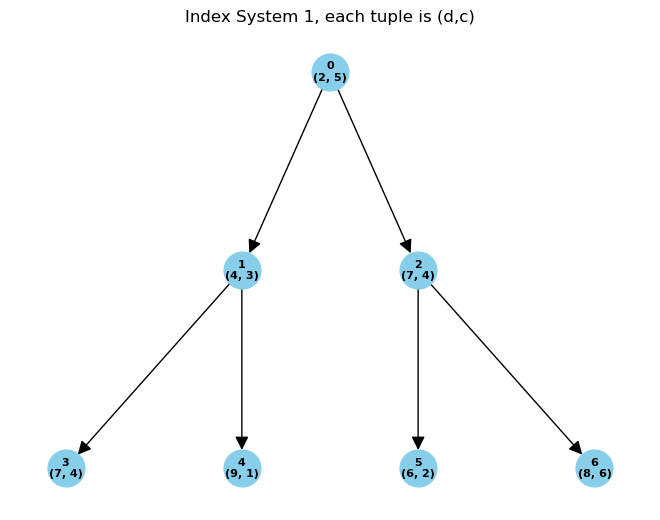

In [4]:
# Number of stages (including the root) in the tree
num_stages = 3

# Branching factor (number of children for each node)
branching_factor = 2

# Create a directed graph
G = nx.DiGraph()

# Add the root node
root_node = 0
G.add_node(root_node)

# Recursively add children to the graph
add_children(G, root_node, num_stages-1, branching_factor)

# Assign values 'c' and 'd' to each node
node_values = {node: {'c': c[node], 'd': d[node]} for node in G.nodes()}

# Add values as node attributes
nx.set_node_attributes(G, values=node_values)

# Use graphviz_layout for tree layout
pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

# Plot the tree
labels = {node: f"{node}\n({G.nodes[node]['d']}, {G.nodes[node]['c']})" for node in G.nodes()}
nx.draw(G, pos, with_labels=True, labels=labels, node_size=700, node_color="skyblue", font_size=8, font_color="black", font_weight="bold", arrowsize=20)
plt.title("Index System 1, each tuple is (d,c)")
plt.show()

Build the sets 
1. P(n) as the set of all nodes on the path from the rootof T to node n (including node n and the root).
2. P_bar(n) as P(n) excluding node n.
3. T(n) is the subtree from node n. 

In [5]:
N = G.number_of_nodes()

# each element is the list of all nodes on the path from the root of T to node n (including node n and the root)
P = []
# same as P but not including node n 
P_bar = []
# each element is a subtree as list of nodes with that node n as root
T = []

for i in range(N):
    P.append(nx.shortest_path(G, source=0, target=i))
    P_bar.append(P[i][:-1])
    T.append(list(dfs_tree(G, i).nodes()))

To apply the Primal Algorithm, we need to find the set A(n), the set of closest descendants of n with positive production levels.

In [6]:
# set of closest descendants of n with positive production levels
def find_A(n, x):
    A = []
    for m in T[n][1:]:
        condition1 = (x[m]>0)
        condition2 = all(x[k] == 0 for k in [item for item in P_bar[m] if item not in P[n]])
        if condition1 and condition2:
            A.append(m)
    return A

Now we can apply the Primal Algorithm

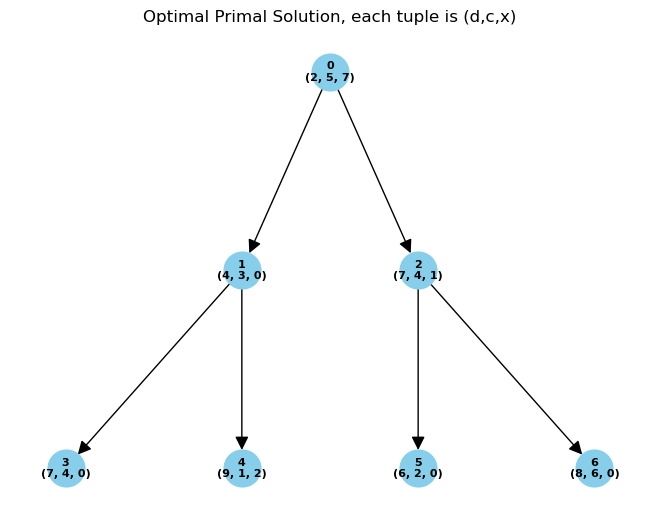

In [7]:
# Initialize x
x = []
for i in range(N):
    if i == 0:
        x.append(max(0, d[i]))
    else:
        x.append(max(0, d[i]- max(d[i] for i in P_bar[i])))

k = N - 1 - branching_factor**(num_stages-1)

while k >= 0:
    A_k = find_A(k, x)
    # if A_k is not empty, we proceed as in algorithm 1
    if A_k:
        s_k = sum(c[m] for m in A_k)
        delta_k = min(x[m] for m in A_k)
        if c[k] < s_k:
            x[k] = x[k] + delta_k
            for m in A_k:
                x[m] = x[m] - delta_k
        else:
            k -= 1 
    # A_k is empty, there is nothing to update
    else:
        k -= 1

# Plot the tree
labels = {node: f"{node}\n({G.nodes[node]['d']}, {G.nodes[node]['c']}, {x[node]})" for node in G.nodes()}
nx.draw(G, pos, with_labels=True, labels=labels, node_size=700, node_color="skyblue", font_size=8, font_color="black", font_weight="bold", arrowsize=20)
plt.title("Optimal Primal Solution, each tuple is (d,c,x)")
plt.show()

This matches the paper's results

Now we can move on to the Dual Algorithm. Firstly, we need to rank the nodes based on their cumulative demand d(n). Then we relabel the nodes to obtain Index System 2.

In [8]:
ranks = rankdata(np.negative(d), method='ordinal')-1
# Create a mapping between old node names and new ranks
mapping = {old_node: new_rank for old_node, new_rank in zip(range(N), ranks)}
# Create a new graph with updated node names
new_G = nx.relabel_nodes(G, mapping)

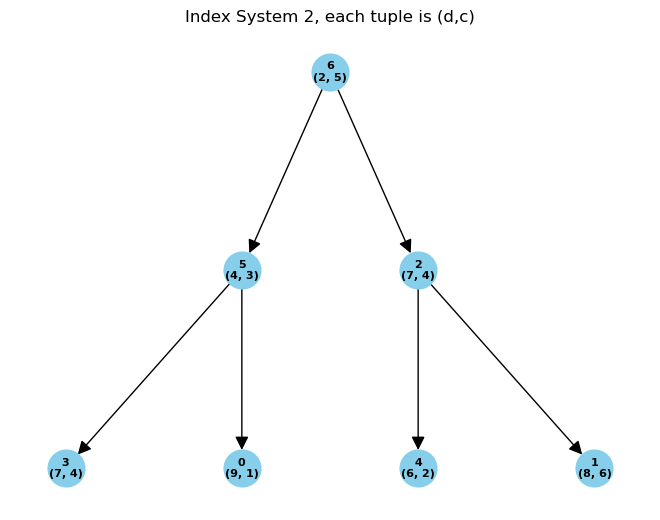

In [9]:
# Draw the new graph with updated node names
new_pos = nx.nx_agraph.graphviz_layout(new_G, prog='dot')
labels = {node: f"{node}\n({new_G.nodes[node]['d']}, {new_G.nodes[node]['c']})" for node in new_G.nodes()}
nx.draw(new_G, new_pos, with_labels=True, labels=labels, node_size=700, node_color="skyblue", font_size=8, font_color="black", font_weight="bold", arrowsize=20)
plt.title("Index System 2, each tuple is (d,c)")
plt.show()

Because we use a different Index System, we need to adapt set P to new_P and c to new_c. We can obtain new_c from new_G by get_node_attributes, then apply the Dual Algorithm.

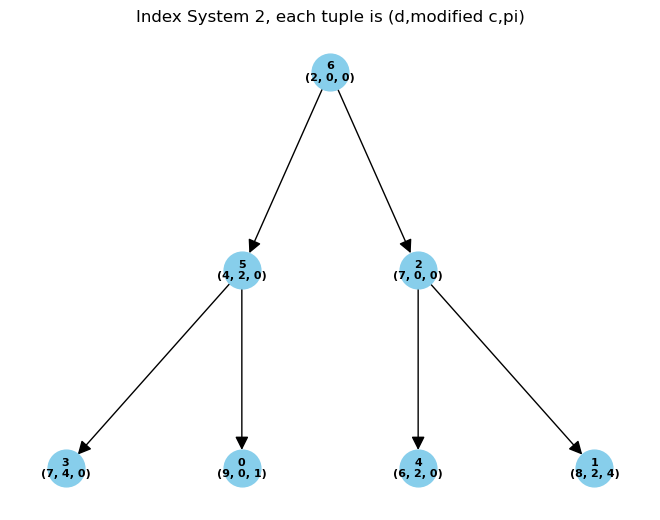

In [10]:
# each element is the list of all nodes on the path from the root of T to node n (including node n and the root)
new_P = []
for i in range(N):
    new_P.append(nx.shortest_path(new_G, source=ranks[0], target=i))

# this is c with adjusted order for Index System 2
new_c = nx.get_node_attributes(new_G, 'c')

pi = []

for k in range(N):
    pi.append(min(new_c[n] for n in new_P[k]))
    for n in new_P[k]:
        new_c[n] = new_c[n] - pi[k]

# Draw the new graph with updated node names
new_pos = nx.nx_agraph.graphviz_layout(new_G, prog='dot')
labels = {node: f"{node}\n({new_G.nodes[node]['d']}, {new_c[node]}, {pi[node]})" for node in new_G.nodes()}
nx.draw(new_G, new_pos, with_labels=True, labels=labels, node_size=700, node_color="skyblue", font_size=8, font_color="black", font_weight="bold", arrowsize=20)
plt.title("Index System 2, each tuple is (d,modified c,pi)")
plt.show()

This matches the paper's results.

# All methods: Solver, Primal Algorithm, Dual Algorithm

Now we want to compare the 2 implemented algorithms to the solver and check their results.

Firstly, we build the tree, find all the necessary sets and generate the parameters for the original problem (2) from paper.

In [11]:
# Number of stages (including the root) in the tree
num_stages = 3

# Branching factor (number of children for each node)
branching_factor = 2

# Create a directed graph
G = nx.DiGraph()

# Add the root node
root_node = 0
G.add_node(root_node)

# Recursively add children to the graph
add_children(G, root_node, num_stages-1, branching_factor)

N = G.number_of_nodes()

# each element is the list of all nodes on the path from the root of T to node n (including node n and the root)
P = []
# same as P but not including node n 
P_bar = []
# each element is a subtree as list of nodes with that node n as root
T = []
for i in range(N):
    P.append(nx.shortest_path(G, source=0, target=i))
    P_bar.append(P[i][:-1])
    T.append(list(dfs_tree(G, i).nodes()))

# Set the seed for reproducibility
seed_value = 1
np.random.seed(seed_value)

# per-unit production cost
alpha = np.random.uniform(1, 10, N)

# per-unit holding cost
beta = np.random.uniform(1, 10, N)

# demand 
delta = np.random.uniform(50, 100, N)

# The probabability for each node
uniform_samples = np.random.uniform(0, 1, N)
q = uniform_samples / np.sum(uniform_samples)

# Find the parent of each node 
parents = nx.predecessor(G, root_node)

Then we build the model according to problem (2) from paper, and solve it using GLPK.

In [12]:
def solve_GLPK():    
    prob = LpProblem("test1", LpMinimize)

    # Create variables
    x = LpVariable.dicts("x", range(N), lowBound=0)
    I = LpVariable.dicts("I", range(N), lowBound=0)
    I_a = LpVariable.dicts("I_a", range(N), lowBound=0)


    # Set objective
    prob += lpSum(q[i] * (alpha[i] * x[i] + beta[i] * I[i]) for i in range(N)), "Objective"

    for i in range(N):
        if i == 0:
            prob += I_a[i] == 0
        else:
            prob += I_a[i] == I[parents[i][0]]
        prob += I_a[i] + x[i] == I[i] + delta[i]
    
    # Solve the linear programming problem with GLPK solver
    prob.solve(GLPK())

    return prob.objective.value()

In [13]:
solve_GLPK()

202.57486682860915

We also obtain the function for the Primal Alogrithm, adding an extra part of transforming parameters to d, c, and c_bar.

In [14]:
# Transform the parameters to d and c
d = []
c = []
for n in range(N):
    d.append(sum(delta[m] for m in P[n]))
    c.append(q[n] * (alpha[n] + sum(q[m]*beta[m] for m in T[n])/q[n]))
c_bar = sum(q*beta*d)

In [15]:
def primal(): 
    # Initialize x
    x = []
    for i in range(N):
        if i == 0:
            x.append(max(0, d[i]))
        else:
            x.append(max(0, d[i]- max(d[i] for i in P_bar[i])))

    k = N - 1 - branching_factor**(num_stages-1)

    while k >= 0:
        A_k = find_A(k, x)
        # if A_k is not empty, we proceed as in algorithm 1
        if A_k:
            s_k = sum(c[m] for m in A_k)
            delta_k = min(x[m] for m in A_k)
            if c[k] < s_k:
                x[k] = x[k] + delta_k
                for m in A_k:
                    x[m] = x[m] - delta_k
            else:
                k -= 1 
        # A_k is empty, there is nothing to update
        else:
            k -= 1
    return np.array(c) @ np.array(x) - c_bar

In [16]:
primal()

202.5747361879893

The Primal optimal objective value matches that of Solver method.

Similarly, we obtain the Dual Algorithm. It seems like there is a typo in the paper where the objective function of the dual problem should also subtract c_bar. Adding this term to the Dual Algorithm helps us to achieve the same results as Primal's and Solver's.

In [17]:
# Transform the parameters to c and d
d = []
c = []
for n in range(N):
    d.append(sum(delta[m] for m in P[n]))
    c.append(q[n] * (alpha[n] + sum(q[m]*beta[m] for m in T[n])/q[n]))
c_bar = sum(q*beta*d)

# Assign values 'c' and 'd' to each node
node_values = {node: {'c': c[node], 'd': d[node]} for node in G.nodes()}

# Add values as node attributes
nx.set_node_attributes(G, values=node_values)

ranks = rankdata(np.negative(d), method='ordinal')-1
# Create a mapping between old node names and new ranks
mapping = {old_node: new_rank for old_node, new_rank in zip(range(N), ranks)}
# Create a new graph with updated node names
new_G = nx.relabel_nodes(G, mapping)

# each element is the list of all nodes on the path from the root of T to node n (including node n and the root)
new_P = []
for i in range(N):
    new_P.append(nx.shortest_path(new_G, source=ranks[0], target=i))

# this is c with adjusted order for Index System 2
new_c = nx.get_node_attributes(new_G, 'c')
new_d = nx.get_node_attributes(new_G, 'd')


In [18]:
def dual():
    pi = []

    for k in range(N):
        pi.append(min(new_c[n] for n in new_P[k]))
        for n in new_P[k]:
            new_c[n] = new_c[n] - pi[k]

    obj_val = sum(new_d[n]*pi[n] for n in range(N))
    
    return obj_val-c_bar

In [19]:
dual()

202.57473618798917

Since all 3 methods' objective values match, we assume our implementation is correct and move on to the last part.

# Compare all 3 methods' running time

Below is the main experiment. Instead of reimplementing all 18 instances from paper as it requires long computation time, we simply want to run some moderately big instances. The goal is to get a similar conclusion that Dual > Primal > Solver in terms of speed. 

Note that we exclude the parameters transformation of c and d in Primal and Dual Algorithm. Also, we exclude the transformation of G to new_G, P to new_P, c to new_c, and d to new_d in Dual Algorithm. Although the transformation can be a hassle and can take some time, it is possible to build new_G directly instead of adapting it from G. This process can be seen as building a tree in the background and not part of the algorithm like in Solver or Primal Algorithm.

In [20]:
num_stages_list = [4, 5, 6, 7]
branching_factor_list = [6, 5, 4, 3]

N_list = np.zeros(len(num_stages_list))
final_runningtime = np.zeros((len(num_stages_list), 5)) # 3 columns for methods and 2 columns for percentages
for a in range(len(num_stages_list)):
    seed_runningtime = np.zeros((10, 3)) # running times in order of (s)olver, (p)rimal, (d)ual for different seeds
    for seed in range(10):
        ##### Build the tree and generate parameters ####
        # Create a directed graph
        G = nx.DiGraph()

        # Add the root node
        root_node = 0
        G.add_node(root_node)

        # Recursively add children to the graph
        add_children(G, root_node, num_stages_list[a]-1, branching_factor_list[a])

        N = G.number_of_nodes()
        N_list[a] = N
        # each element is the list of all nodes on the path from the root of T to node n (including node n and the root)
        P = []
        # same as P but not including node n 
        P_bar = []
        # each element is a subtree as list of nodes with that node n as root
        T = []
        for i in range(N):
            P.append(nx.shortest_path(G, source=0, target=i))
            P_bar.append(P[i][:-1])
            T.append(list(dfs_tree(G, i).nodes()))

        np.random.seed(seed)

        # per-unit production cost
        alpha = np.random.uniform(1, 10, N)

        # per-unit holding cost
        beta = np.random.uniform(1, 10, N)

        # demand 
        delta = np.random.uniform(50, 100, N)

        # The probabability for each node
        uniform_samples = np.random.uniform(0, 1, N)
        q = uniform_samples / np.sum(uniform_samples)
        
        # Find the parent of each node 
        parents = nx.predecessor(G, root_node)

        # Transform the parameters to c and d
        d = []
        c = []
        for n in range(N):
            d.append(sum(delta[m] for m in P[n]))
            c.append(q[n] * (alpha[n] + sum(q[m]*beta[m] for m in T[n])/q[n]))
        c_bar = sum(q*beta*d)

        # Assign values 'c' and 'd' to each node
        node_values = {node: {'c': c[node], 'd': d[node]} for node in G.nodes()}

        # Add values as node attributes
        nx.set_node_attributes(G, values=node_values)

        ranks = rankdata(np.negative(d), method='ordinal')-1
        # Create a mapping between old node names and new ranks
        mapping = {old_node: new_rank for old_node, new_rank in zip(range(N), ranks)}
        # Create a new graph with updated node names
        new_G = nx.relabel_nodes(G, mapping)

        # each element is the list of all nodes on the path from the root of T to node n (including node n and the root)
        new_P = []
        for i in range(N):
            new_P.append(nx.shortest_path(new_G, source=ranks[0], target=i))

        # this is c with adjusted order for Index System 2
        new_c = nx.get_node_attributes(new_G, 'c')
        new_d = nx.get_node_attributes(new_G, 'd')

        ##########################################################
        start_time = time.time()
        solver_obj_val = solve_GLPK()
        end_time = time.time()
        seed_runningtime[seed,0] = end_time - start_time

        start_time = time.time()
        primal_obj_val = primal()
        end_time = time.time()
        seed_runningtime[seed,1] = end_time - start_time

        start_time = time.time()
        dual_obj_val = dual()
        end_time = time.time()
        seed_runningtime[seed,2] = end_time - start_time

        assert not (solver_obj_val == primal_obj_val == dual_obj_val), "Methods' results do not match"

        avg_runningtime = np.mean(seed_runningtime, axis=0)
        # add solver and primal time
        final_runningtime[a,:2] = avg_runningtime[:2]
        # add primal percentage
        final_runningtime[a, 2] = avg_runningtime[1] / avg_runningtime[0] * 100
        # add dual time 
        final_runningtime[a, 3] = avg_runningtime[2]
        # add dual percentage
        final_runningtime[a, 4] = avg_runningtime[2] / avg_runningtime[0] * 100

Now we merge all the necessary arrays to obtain a table of running time comparison for all 3 methods.

In [21]:
merged = np.hstack((np.array(num_stages_list)[:, np.newaxis], np.array(branching_factor_list)[:, np.newaxis], N_list[:, np.newaxis], final_runningtime))

In [22]:
df = pd.DataFrame(merged, columns=['T', 'B', 'N', 'Solver', 'Primal', '%', 'Dual', '%'])
df

,T,B,N,Solver,Primal,%,Dual,%
0,4.0,6.0,259.0,0.043125,0.002380,5.519424,0.000508,1.177568
1,5.0,5.0,781.0,0.112593,0.009421,8.367464,0.001321,1.173514
2,6.0,4.0,1365.0,0.186496,0.016998,9.114297,0.002253,1.207970
3,7.0,3.0,1093.0,0.149160,0.013229,8.869101,0.002053,1.376325


Just like the paper, the columns in the table are arranged according to the number of stages (T), the number of branches (B), total number of nodes (N), the actual running time of Solver, the actual running time of the Primal algorithm, the running time of the Primal algorithm as a % of the running time of Solver, the actual running time of the Dual algorithm, the running time of the Dual algorithm as a % of the running time of Solver, respectively.

This result meets our expectation where Dual > Primal > Solver in terms of speed, where both proposed algorithms are significantly faster than the solver. These algorithms would be very helpful for larger scale inventory planning and can be inspirational for other multi-stage stochastic problems.